Image Path:

/home/june/.cache/kagglehub/datasets/borhanitrash/animal-image-classification-dataset/versions/1

In [105]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision
from torch.utils.data import random_split
import random 


In [128]:
dir_path = "/home/june/.cache/kagglehub/datasets/borhanitrash/animal-image-classification-dataset/versions/1/Animals/"
cats = dir_path + "/cats"
dogs = dir_path + "/dogs"
snakes = dir_path + "/snakes"

# Get all image file paths for each animal
cat_paths = [os.path.join(cats, fname) for fname in os.listdir(cats) if os.path.isfile(os.path.join(cats, fname))]
dog_paths = [os.path.join(dogs, fname) for fname in os.listdir(dogs) if os.path.isfile(os.path.join(dogs, fname))]
snake_paths = [os.path.join(snakes, fname) for fname in os.listdir(snakes) if os.path.isfile(os.path.join(snakes, fname))]


image_paths = cat_paths + dog_paths + snake_paths
labels = [0] * len(cat_paths) + [1] * len(dog_paths) + [2] * len(snake_paths)  # 0: cat, 1: dog, 2: snake
class_names = ['cat', 'dog', 'snake']

print(f"Number of cat images: {len(cat_paths)}")
print(f"Number of dog images: {len(dog_paths)}")
print(f"Number of snake images: {len(snake_paths)}")







Number of cat images: 1000
Number of dog images: 1000
Number of snake images: 1000


In [283]:
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),                # Ensure consistent input size
    transforms.RandomHorizontalFlip(),            # Randomly flip images
    transforms.RandomRotation(15),                # Randomly rotate images by ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class AnimalDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=data_transforms):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
            label = torch.tensor(self.labels[idx], dtype=torch.long)
        label = self.labels[idx]
        return image, label
    
    def __split__(self, train_ratio=0.8, val_ratio=0.0, test_ratio=0.2, seed=42):
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
        dataset_size = len(self)
        indices = list(range(dataset_size))
        
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(indices)
        
        # Find indices for each class from the full shuffled list
        class_indices = {0: [], 1: [], 2: []}
        for idx in indices:
            class_indices[self.labels[idx]].append(idx)
        
        # Calculate how many per class for train/val/test
        min_class_len = min(len(class_indices[0]), len(class_indices[1]), len(class_indices[2]))
        n_train = int(train_ratio * min_class_len)
        n_val = int(val_ratio * min_class_len)
        n_test = min_class_len - n_train - n_val
        
        # Pick for each split
        train_indices = class_indices[0][:n_train] + class_indices[1][:n_train] + class_indices[2][:n_train]
        val_indices = class_indices[0][n_train:n_train+n_val] + class_indices[1][n_train:n_train+n_val] + class_indices[2][n_train:n_train+n_val]
        test_indices = class_indices[0][n_train+n_val:n_train+n_val+n_test] + class_indices[1][n_train+n_val:n_train+n_val+n_test] + class_indices[2][n_train+n_val:n_train+n_val+n_test]
        
        # Shuffle each split to mix classes
        np.random.shuffle(train_indices)
        np.random.shuffle(val_indices)
        np.random.shuffle(test_indices)
        
        train_set = torch.utils.data.Subset(self, train_indices)
        val_set = torch.utils.data.Subset(self, val_indices)
        test_set = torch.utils.data.Subset(self, test_indices)
        return train_set, val_set, test_set




dataset = AnimalDataset(image_paths, labels, transform=data_transforms)







In [284]:
from collections import Counter

dataset = AnimalDataset(image_paths, labels, transform=data_transforms)

print(type(dataset))
train_dataset, val_dataset, test_dataset = dataset.__split__(train_ratio=0.85, val_ratio=0, test_ratio=0.15, seed=42)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)


print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Count samples for each class in the training set

train_labels = [dataset.labels[i] for i in train_dataset.indices]

print("Train labels:", train_labels)




label_counts = Counter(train_labels)
for idx, class_name in enumerate(class_names):
    print(f"Number of {class_name} samples in train_dataset: {label_counts.get(idx, 0)}")

<class '__main__.AnimalDataset'>
Train size: 2550
Validation size: 0
Test size: 450
Train labels: [2, 1, 0, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 1, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 2, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 1, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2, 1, 2, 1, 0, 2, 1, 2, 2, 2, 1, 0, 2, 1, 0, 0, 0, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 2, 1, 1, 2, 2, 1, 1, 0, 0, 1, 0, 2, 1

In [104]:
print(f"shape of data : {dataset[0][0].shape}")

shape of data : torch.Size([3, 256, 256])


In [285]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: cat, dog, snake

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 32 * 32)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [286]:
net = NeuralNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.95)

In [287]:

for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        # inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

[1, 100] loss: 1.092
[1, 200] loss: 1.021
[1, 300] loss: 0.905
[1, 400] loss: 0.864
[1, 500] loss: 0.927
[1, 600] loss: 0.881
[2, 100] loss: 0.854
[2, 200] loss: 0.827
[2, 300] loss: 0.833
[2, 400] loss: 0.829
[2, 500] loss: 0.805
[2, 600] loss: 0.803
[3, 100] loss: 0.783
[3, 200] loss: 0.837
[3, 300] loss: 0.781
[3, 400] loss: 0.777
[3, 500] loss: 0.792
[3, 600] loss: 0.793
[4, 100] loss: 0.822
[4, 200] loss: 0.818
[4, 300] loss: 0.779
[4, 400] loss: 0.789
[4, 500] loss: 0.722
[4, 600] loss: 0.806
[5, 100] loss: 0.766
[5, 200] loss: 0.826
[5, 300] loss: 0.706
[5, 400] loss: 0.758
[5, 500] loss: 0.728
[5, 600] loss: 0.696
[6, 100] loss: 0.698
[6, 200] loss: 0.785
[6, 300] loss: 0.694
[6, 400] loss: 0.693
[6, 500] loss: 0.781
[6, 600] loss: 0.719
[7, 100] loss: 0.764
[7, 200] loss: 0.723
[7, 300] loss: 0.713
[7, 400] loss: 0.733
[7, 500] loss: 0.737
[7, 600] loss: 0.737
[8, 100] loss: 0.730
[8, 200] loss: 0.675
[8, 300] loss: 0.683
[8, 400] loss: 0.639
[8, 500] loss: 0.671
[8, 600] loss

In [288]:
torch.save(net.state_dict(), "animal_classifier_aug_30e_m095.pth")
print("Model saved as animal_classifier_aug_30e_m095.pth.pth")

Model saved as animal_classifier_aug_30e_m095.pth.pth


In [289]:
net  = NeuralNet()
net.load_state_dict(torch.load("animal_classifier_aug_30e_m095.pth"))

<All keys matched successfully>

In [290]:
correct = 0
total = 0

net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of the network on the test images: {100 * correct / total:.2f}%")
# Calculate accuracy for each class
# class_correct = [0] * 3
# class_total = [0] * 3
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         # images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):  # Assuming batch size is 4
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1
# for i in range(3):
#     if class_total[i] > 0:
#         print(f"Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")
#     else:
#         print(f"Accuracy of {class_names[i]}: N/A (no training examples)")

Accuracy of the network on the test images: 75.33%


In [291]:

import matplotlib.pyplot as plt
new_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
def load_image(image_path):
    image = Image.open(image_path)
    image = new_transforms(image)
    image = image.unsqueeze(0)
    return image
def predict(image_path):
    image = load_image(image_path)
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = net(image)
        _, predicted = torch.max(output.data, 1)
        
    plt.imshow(image.squeeze(0).permute(1, 2, 0).numpy())
    plt.axis('off')    
    plt.show()
    print(f"Predicted: {class_names[predicted.item()]}")









In [292]:
selectImage = ['predict_path/example_dog1.jpeg' , 'predict_path/cat_example1.jpeg','predict_path/3.jpeg','predict_path/4.jpeg','predict_path/5.jpeg','predict_path/6.jpeg']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].


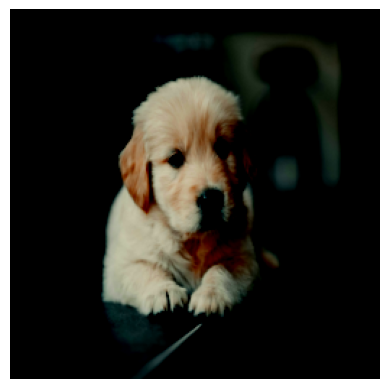

Predicted: cat


In [293]:
predict(selectImage[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].


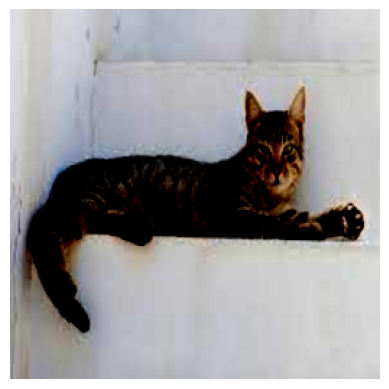

Predicted: snake


In [294]:
predict(selectImage[1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


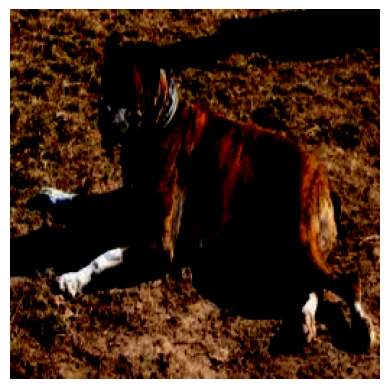

Predicted: dog


In [295]:
predict(selectImage[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


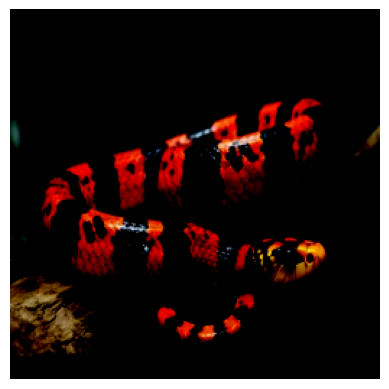

Predicted: snake


In [296]:
predict(selectImage[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


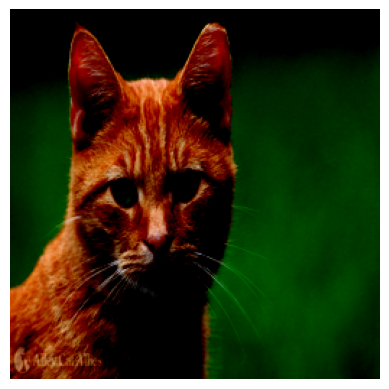

Predicted: dog


In [297]:
predict(selectImage[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


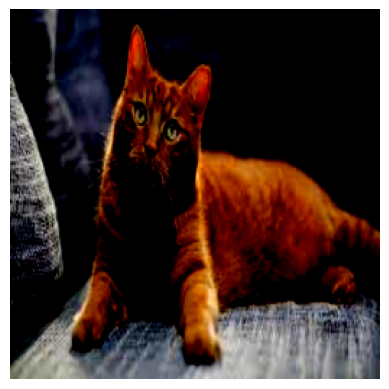

Predicted: cat


In [298]:
predict(selectImage[5])